In [1]:
# standard python utilities
import os
from os.path import join, basename,dirname
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [2]:
git_dir = os.getcwd()
while basename(git_dir) != 'GitHub':
    git_dir = dirname(git_dir)
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
proj_dir = gwfm_dir+'Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'
fig_dir = proj_dir+'/Streambed_seepage/figures/'

hob_dir = join(gwfm_dir, 'HOB_data')

In [3]:
def gdf_bnds(gdf, ax, buf=1):
    gdf_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [gdf.unary_union.buffer(buf)], crs=gdf.crs)
    minx, miny, maxx, maxy = gdf_bnd.bounds.values[0]
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    return(gdf_bnd)



In [4]:
def get_layer_from_elev(elev, botm_slice, nlay):
    """  Return uppermost model layer occupied at least partly by some elevation data
    Parameters
    ----------
    elev: 1D array (n) with elevations matching model elevation units
    botm: 2D array (nlay, n) with layer elevations of model using same x,y locations at elev1D
    """
    elev_lay = np.zeros(len(elev))
    for k in np.arange(0,nlay-1):
        for j in np.arange(0,len(elev)):
            if botm_slice[k,j] > elev[j]:
                elev_lay[j] = k + 1
    return(elev_lay.astype(int))

In [5]:
loadpth =  'C:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage'
model_nam = 'inset_oneto_denier'

model_ws = join(loadpth,model_nam)

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')

In [6]:
m_ver = '' # default no alternate output/input names
# m_ver = '_vka10'


In [7]:
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, model_nam,'rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs='epsg:32610')

In [8]:
strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = (strt_date + pd.Series((m.dis.nper-1)*15).astype('timedelta64[m]'))[0] # SS
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# with SS period near 0 no longer minus one
dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
# astype timedelta64 results in save days
dates_stps = strt_date + (np.repeat(stplen, m.dis.nstp.array).cumsum()*24).astype('timedelta64[h]')


In [9]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper
# dt_ref

In [10]:
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

In [11]:
# characterize streambed into different hydrofacies
tprogs_quants = np.array([0.590, 0.155, 0.197, 0.058]).cumsum()
vka_quants = grid_sfr.strhc1.quantile(tprogs_quants)
vka_quants.index=['mud','sandy mud','sand','gravel']
grid_sfr['facies'] = 'mud'
for n in np.arange(0,len(vka_quants)-1):
    grid_sfr.loc[grid_sfr.strhc1 > vka_quants.iloc[n],'facies'] = vka_quants.index[n+1]

## Sensor data and XS data

In [12]:
df = pd.read_csv(join(hob_dir,'CosumnesRiverPreserve_MW_screened_interval.csv'))
rm_sp = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude,df.Latitude), crs='epsg:4326')
rm_sp = rm_sp.to_crs('epsg:32610')
rm_sp = rm_sp.rename(columns={'Well ID':'Sensor'})

# prepare output for modelgrid join
rm_t = rm_sp[rm_sp['At Oneto-Denier']=='Yes']
rm_t[['top_screen','bot_screen']] = rm_t['Screened Interval (ft)'].str.split('-',n=2, expand=True).astype(float)
# calculate elevation from screened interval depth
rm_t['top_screen_m'] = rm_t['MPE (meters)'] - rm_t.top_screen*0.3048
rm_t['bot_screen_m'] = rm_t['MPE (meters)'] - rm_t.bot_screen*0.3048

# rm_xs = gpd.read_file(proj_dir+ 'rm_xs/rm_xs.shp')

C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ajcalder\anaconda3\envs\geo_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [13]:
# find HOB well grid cell
rm_grid = gpd.sjoin(rm_t, grid_p)
rm_grid['short_id'] = rm_grid.Sensor.str.replace('MW_','')

# get model layer for heads
hob_row = rm_grid.row.values-1
hob_col = rm_grid.column.values-1

avg_screen = rm_grid[['top_screen_m','bot_screen_m']].mean(axis=1).values
rm_grid['lay'] = get_layer_from_elev(avg_screen, m.dis.botm[:,hob_row, hob_col], m.dis.nlay)


In [14]:
# XS are every 100 m
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')


In [15]:
XSg = pd.read_csv(join(model_ws,'04_XSg_filled.csv'))
XSg = gpd.GeoDataFrame(XSg, geometry = gpd.points_from_xy(XSg.Easting, XSg.Northing), crs='epsg:32610')

# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

In [16]:

# correspond XS to sensors
rm_elev = gpd.sjoin_nearest(XSg, rm_t, how='right',lsuffix='xs', rsuffix='rm')
#MW_11, MW_CP1 had doubles with sjoin_nearest due to XS duplicates from Oneto_Denier
rm_elev = rm_elev.drop_duplicates(['xs_num','Sensor'])

# Plot Groundwater Observed vs Simulated
We need to validate that the local model of Oneto-Denier is adequately representing stream-aquifer interactions so it can be used to quantify storage changes and particle age.

- field data shows fall lows around -2 to 2 m with peaks to 8m with winter
- simulated data shows fall lows around 3-5 meters with peaks to 8 m
- the simulated data as usual isn't showing as extreme reactions as the real data is showing which could be partly due to an issue with the initial steady state levels, the peaks match which means the stream stage is peaking close to reality. I may need to consider adding evapotranspiration as the GDEs are likely pulling water
- adding EVT and RCH together brought the steady state conditions to match observed conditions, but way over-estimated the winter peaks

In [17]:
# load field data
gwl = pd.read_csv(join(hob_dir,'AllSets.csv'), parse_dates=['dt'], index_col=['dt'])
gwl.index = gwl.index.tz_localize(None)
# filter for wells within the grid
gwl = gwl.loc[:,gwl.columns.isin(rm_t.Sensor.values)]
# filter for dates within the period
gwl = gwl.loc[strt_date:end_date]
# long format
gwl_long = gwl.reset_index().melt(id_vars='dt', var_name='Well',value_name='obs')
# gwl.plot()

In [18]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
# extract time series of heads for each desired location
mw_hds = hdobj.get_ts(list(zip(rm_grid['lay'], hob_row, hob_col)))
mw_hds = pd.DataFrame(mw_hds, columns=['time']+rm_grid.Sensor.tolist())
# convert to hourly to maintain more precision in DT
mw_hds['dt'] = strt_date+(mw_hds.time.values*24 ).astype('timedelta64[h]')
# mw_hds['dt'] = dt_ref.dt

mw_gwl = mw_hds.drop(columns=['time'])
# long format for id join with observed dat
mw_long = mw_gwl.melt(id_vars='dt', var_name='Well',value_name='sim')

# sns.lineplot(mw_long, x='dt',y='sim',hue='Well')
# mw_gwl.set_index('dt').plot()

In [19]:
hob_long = gwl_long.join(mw_long.set_index(['dt','Well']), on=['dt','Well'], how='inner')
# convert to long format for seaborn plot
hob_long = hob_long.melt(id_vars=['dt','Well'],var_name='type', value_name='gwe')

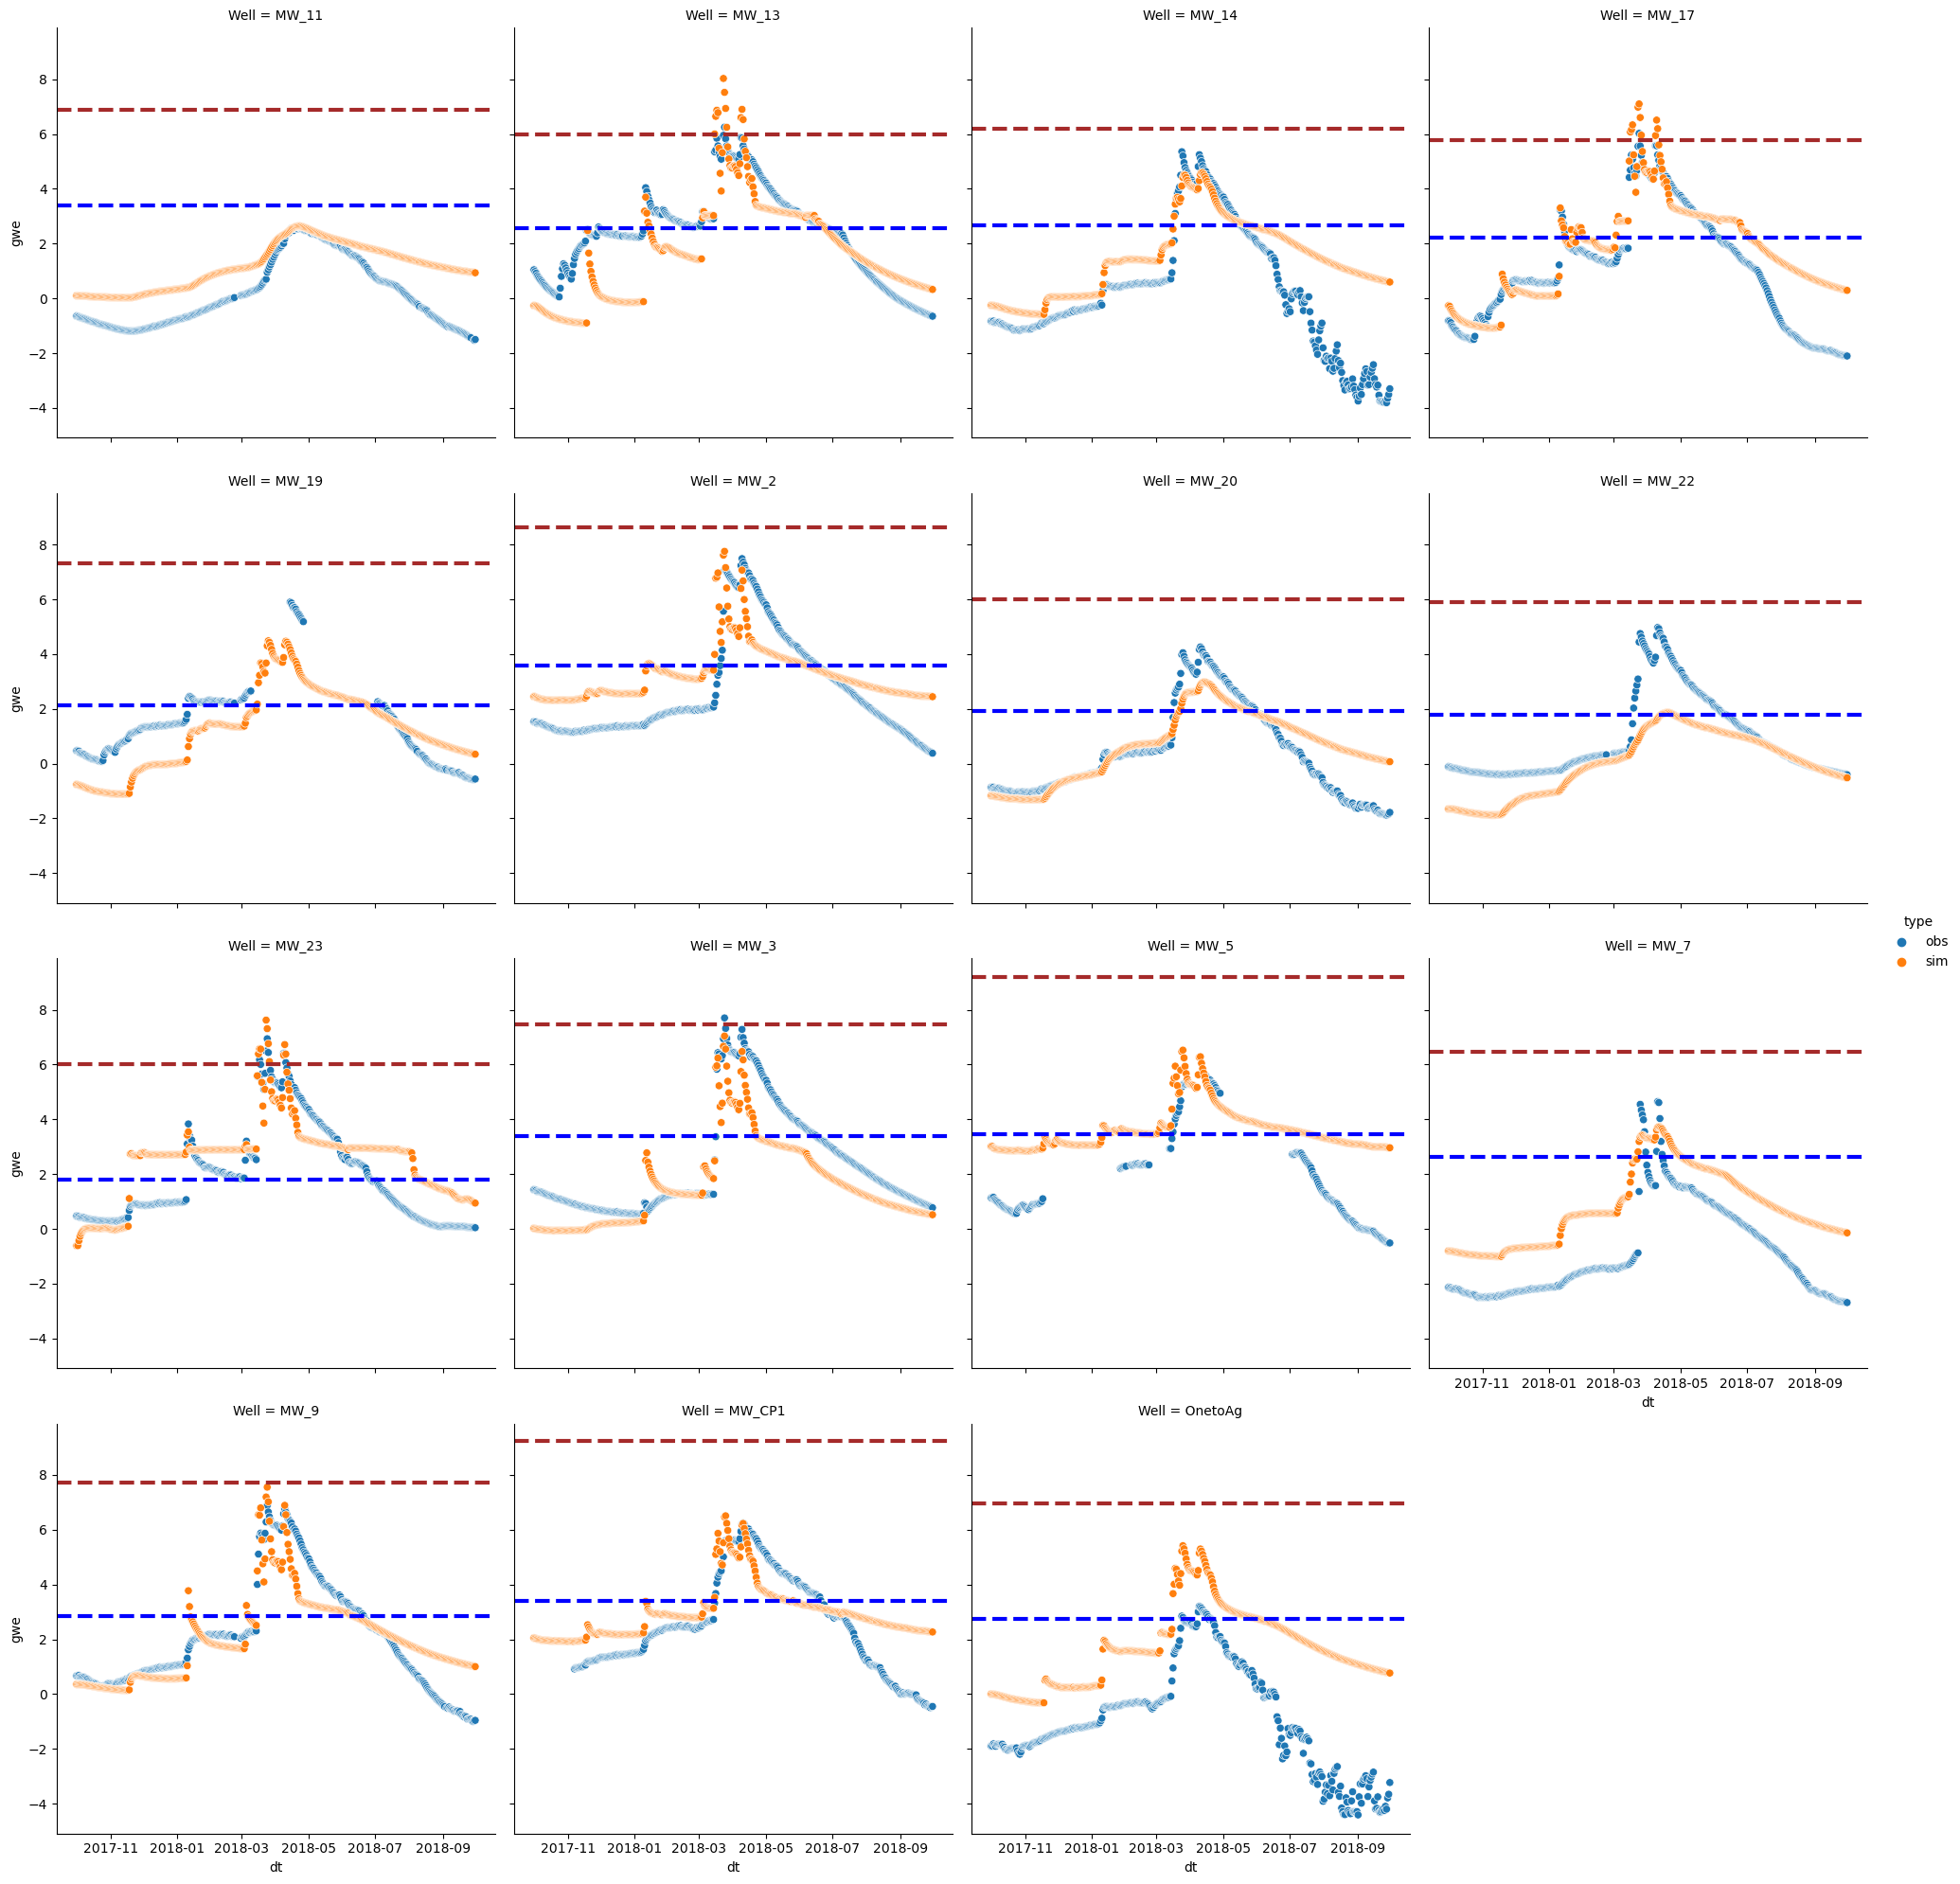

In [20]:
# hob_long, x='dt',y='
g = sns.relplot(hob_long, x='dt',y='gwe',col='Well',hue='type', col_wrap=4)

axes = g.axes.flatten()
mw = hob_long.Well.unique()

for n in np.arange(0,len(axes)):
    mw_dat = rm_elev[rm_elev.Sensor ==mw[n]]
    axes[n].axhline(mw_dat['MPE (meters)'].values[0], ls='--', linewidth=3, color='brown')
    axes[n].axhline(mw_dat['z_m_min_cln'].values[0]-1, ls='--', linewidth=3, color='blue')

In [21]:
# aggregate error for spatial plotting by month average?
# hob_diff = hob_long.copy()
# hob_diff
# hob_diff['month'] = 
# hob_diff.dt.dt.month
hob_diff = hob_long.pivot_table(index=['dt','Well'],values='gwe',columns='type')
hob_diff['h_diff'] = hob_diff.sim - hob_diff.obs

hob_diff_mon = hob_diff.reset_index().set_index('dt').groupby('Well').resample('MS').mean()
hob_diff_mon = hob_diff_mon[['h_diff']].reset_index()
# hob_diff_mon

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_9780\2280401676.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hob_diff_mon = hob_diff.reset_index().set_index('dt').groupby('Well').resample('MS').mean()


In [22]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
lak_extent = gpd.read_file(join(lak_shp,'LCRFR_ModelDom_2017/LCRFR_2DArea_2015.shp' )).to_crs('epsg:32610')


Text(0.5, 1.0, '2018-02-01')

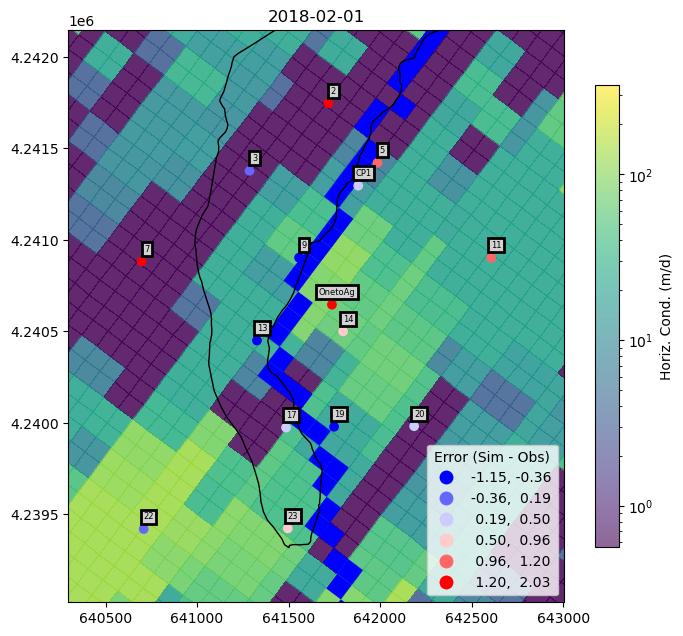

In [23]:
# t = '2018-06-01'
t = '2018-02-01'

diff_plt = hob_diff_mon[hob_diff_mon.dt == t]
# diff_plt['sign'] = np.sign(diff_plt.h_diff)
diff_plt = rm_grid.join(diff_plt.set_index('Well'),on='Sensor')

fig,ax=plt.subplots(figsize=(8, 8))
# m_domain.plot(ax=ax,color='None')
mapview = flopy.plot.PlotMapView(model=m,ax=ax)
a = m.upw.hk.array
csa = mapview.plot_array(a[0,:,:], norm=mpl.colors.LogNorm(), alpha=0.6)
cb = plt.colorbar(csa, shrink=0.75,ax=ax)
cb.set_label('Horiz. Cond. (m/d)')

gdf_bnd = gdf_bnds(rm_grid,buf=400,ax=ax)

grid_sfr.plot(color='blue', ax=ax)
lak_extent.plot(color='none', ax=ax)
diff_plt.plot('h_diff', scheme='Quantiles', k = 6, ax=ax,
                  legend=True,cmap='bwr', legend_kwds={'loc':'lower right' ,'title':'Error (Sim - Obs)'})

rm_grid.apply(lambda x: ax.annotate(x.short_id, xy=x.geometry.coords[0], ha='center', fontsize=6,
                                    xytext = (5,10), textcoords='offset pixels',
#                                     arrowprops = {'shrink':1},
                                    bbox=dict(boxstyle="square,pad=0.3", fc="lightgrey", ec="black", lw=2)
                                                        ),axis=1);
ax.set_title(t)

In [24]:
sfr_dir = gwfm_dir+'/SFR_data/'
# m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')


In [25]:
mcc_d = pd.read_csv(sfr_dir+'MCC_flow_obs_all.csv', parse_dates = ['DATE TIME'], index_col='DATE TIME')
mcc_d = mcc_d[(mcc_d.index>strt_date)&(mcc_d.index<end_date)]



In [ ]:
# load local stream stage data

## Lake plotting

In [26]:
gage_cols = ['time','stage','volume','conc','inflows','outflows','conductance','error']

def read_gage(gagenam):
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')
    cols = gage.columns[1:-1]
    gage = gage.dropna(axis=1)
    gage.columns = cols
    strt_date = pd.to_datetime(m.dis.start_datetime)
    gage['dt'] = strt_date+(gage.Time*24).astype('timedelta64[h]')
    gage = gage.set_index('dt')
#     gage['name'] = run
    return(gage)
lak_out = read_gage(join(model_ws, 'MF.gage1.go'))

<>:4: DeprecationWarning: invalid escape sequence '\s'
<>:4: DeprecationWarning: invalid escape sequence '\s'
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_9780\3199769597.py:4: DeprecationWarning: invalid escape sequence '\s'
  gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')


<AxesSubplot: xlabel='dt'>

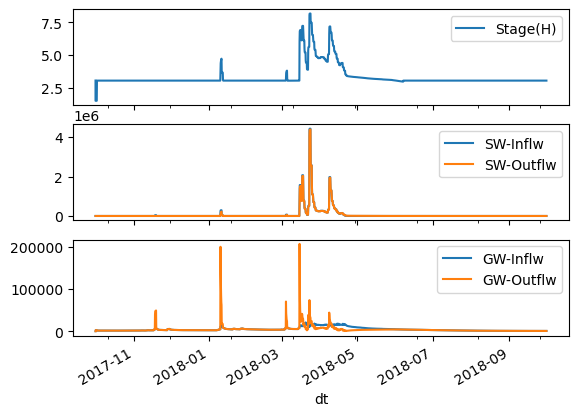

In [27]:
fig,ax = plt.subplots(3,1, sharex=True)
lak_out.plot(y=['Stage(H)'], ax = ax[0]) #dry all the time
# lak_out.columns # GW-Inflw, GW-Outflw, SW-Inflw, SW-Outflw
lak_out.plot(y=['GW-Inflw', 'GW-Outflw'], ax=ax[2]) # there is gw inflow
lak_out.plot(y=['SW-Inflw', 'SW-Outflw'], ax=ax[1]) # there is sw inflow
# the lake error is 100%, even setting initial stage above minimum the lake stays at minimum entire time

## SFR Plotting

In [28]:
# grid_sfr = pd.DataFrame().from_records(m.sfr.reach_data).rename(columns={'i':'row','j':'column'})
# grid_sfr[['row','column']] += 1 # convert to 1 based to match with SFR output
pd_sfr = grid_sfr.set_index(['i','j'])[['rchlen','strtop']]
pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws):
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+m_ver+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    sfrdf[['row','column']]-=1 # convert to python
    cmd2cfs = 1/((0.3048**3)*86400) # cubic meters per day to cfs

#     sfrdf_plot = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
    sfrdf_plot = sfrdf.join(pd_sfr ,on=['row','column'],how='inner',lsuffix='_all')
    # dependent on number of time steps
    sfrdf_plot['Qin_cfs'] = sfrdf_plot.Qin * cmd2cfs
    sfrdf_plot['Qout_cfs'] = sfrdf_plot.Qout * cmd2cfs
    sfrdf_plot['Qaquifer_cfs'] = sfrdf_plot.Qaquifer * cmd2cfs
    sfrdf_plot = sfrdf_plot.set_index('dt')
    return(sfrdf_plot)



In [29]:
sfrdf =  clean_sfr_df(model_ws)

In [30]:
sfrdf.columns
# isegs = sfrdf.segment.unique()
quants = sfrdf.Cond.quantile([0.05,0.25,0.5,0.75,0.95])
sfrdf[sfrdf.Cond > quants[0.95]].segment.unique()

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 41, 43, 44, 68, 69,
       70, 71, 72, 73, 74])

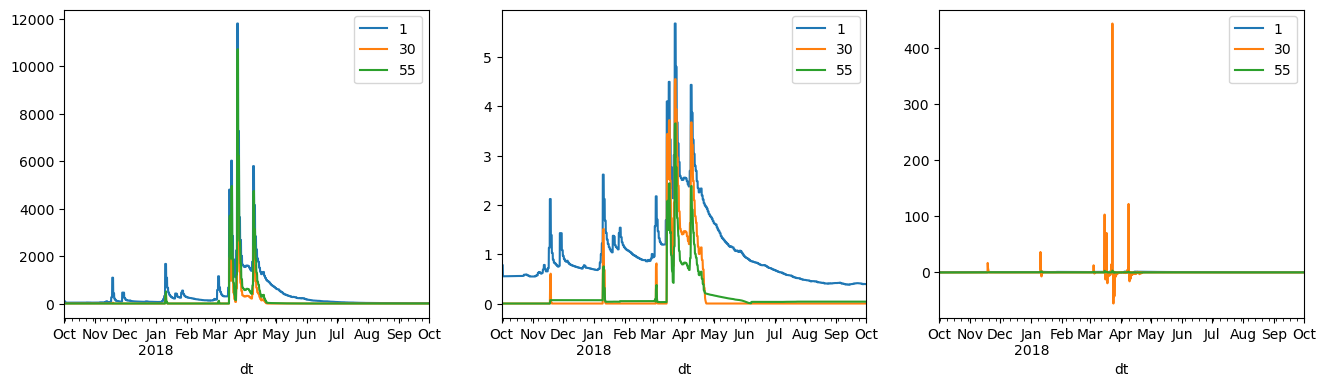

In [31]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
for s in [1,30,55]:
    sfrdf[sfrdf.segment==s].plot(y='Qout_cfs',ax=ax[0], label=s)
    sfrdf[sfrdf.segment==s].plot(y='depth',ax=ax[1], label=s)
    sfrdf[sfrdf.segment==s].plot(y='Qaquifer_cfs',ax=ax[2], label=s)


In [118]:

# far and beyond the stream system is losing
# create different column for stream losing vs gaining seeapge
sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )

sfr_sum = sfrdf.groupby('dt').sum(numeric_only=True)
# sfr_sum.cumsum().plot(y=['Qrech','Qbase'])
# sfr_sum.plot(y=['Qrech','Qbase'])
# plt.yscale('log')
# qaq = sfrdf.groupby('dt').sum(numeric_only=True)['Qaquifer']
# qaq.cumsum().plot(y='Qaquifer') # Qaquifer

In [131]:
# grid_sfr[['iseg','ireach','facies']]
sfr_facies = sfrdf.join(grid_sfr.set_index(['iseg','ireach'])[['facies']], on=['segment','reach'])
sfr_facies_sum = sfr_facies.groupby(['dt','facies']).sum(numeric_only=True)
sfr_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)



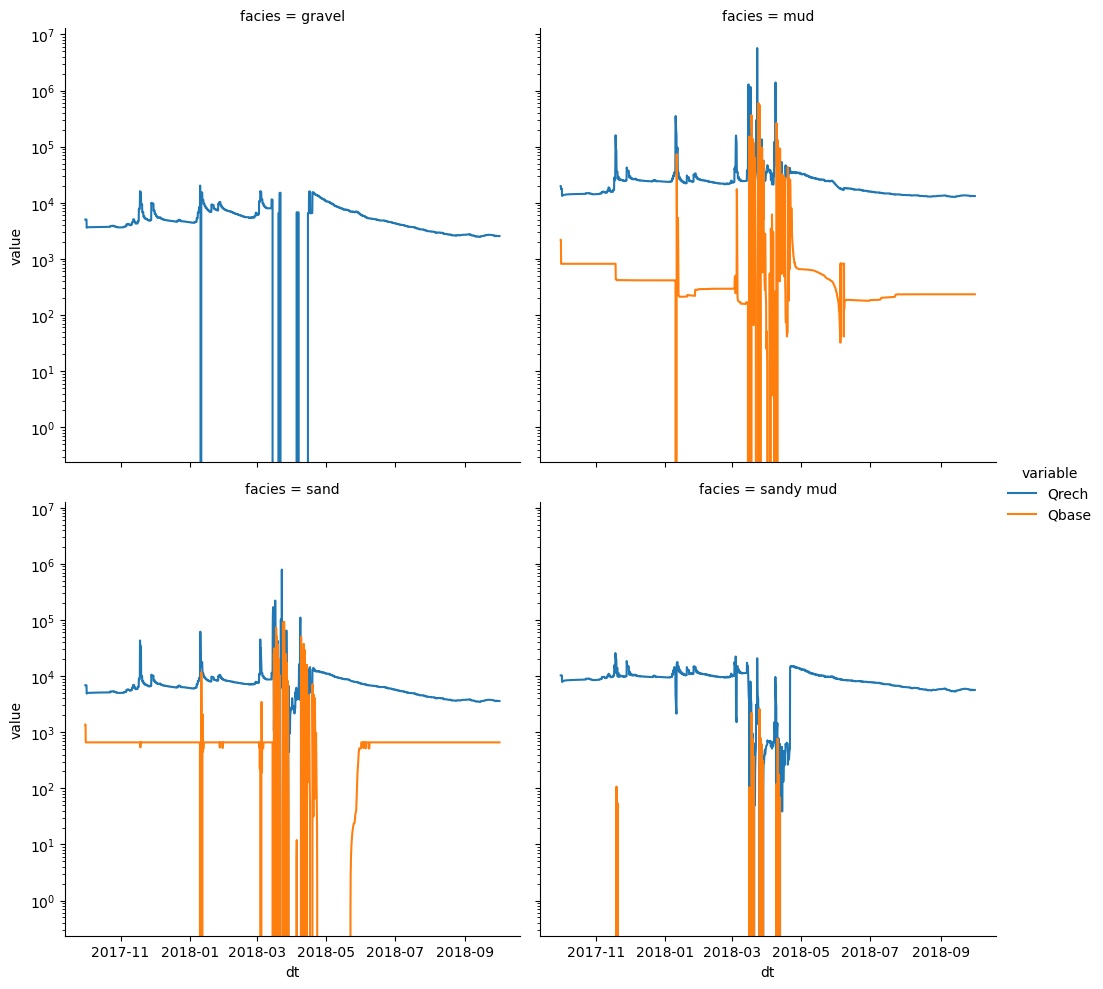

In [136]:
g = sns.relplot(sfr_facies_sum, x='dt',y='value',hue='variable', kind='line',
            col = 'facies', col_wrap=2)
g.set(yscale='log')

In [33]:
# downstream segments increase in number so the issues with large conductance are at the downstream end
# import seaborn as sns
# sns.relplot(sfrdf[sfrdf.Cond > quants[0.95]], x='dt', y='Qout_cfs',col='segment', kind='line', col_wrap=4)

### Plot stream discretization

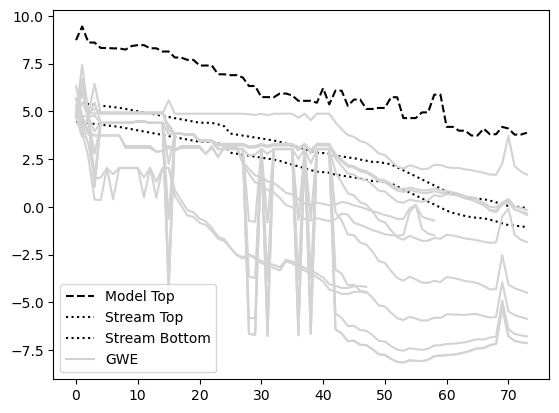

In [34]:
plt.plot(m.dis.top.array[grid_sfr.i, grid_sfr.j], label='Model Top', ls='--',color='black')
plt.plot(m.sfr.reach_data.strtop, label= 'Stream Top', ls=':',color='black')
plt.plot(m.sfr.reach_data.strtop-m.sfr.reach_data.strthick, label= 'Stream Bottom', ls=':',color='black')

# spd_hd = dt_ref[dt_ref.dt == '2020-05-21'].kstpkper.values[0]
# head = hdobj.get_data(spd_hd)[0][0]

for t in spd_stp[0::30]: # every 7 days 
#     spd_hd = dt_ref[dt_ref.dt == t].kstpkper.values[0]
    head = hdobj.get_data(t)[grid_sfr.k, grid_sfr.i, grid_sfr.j]
    head = head[head!=-999.99]
    plt.plot(head, color='lightgray')
plt.plot(head,label = 'GWE',  color='lightgray')

plt.legend()

## Grid wide head distribution

In [35]:
# sfr_gpd = grid_p.set_index(['row','column']).loc[list(zip(grid_sfr.row+1, grid_sfr.column+1))]

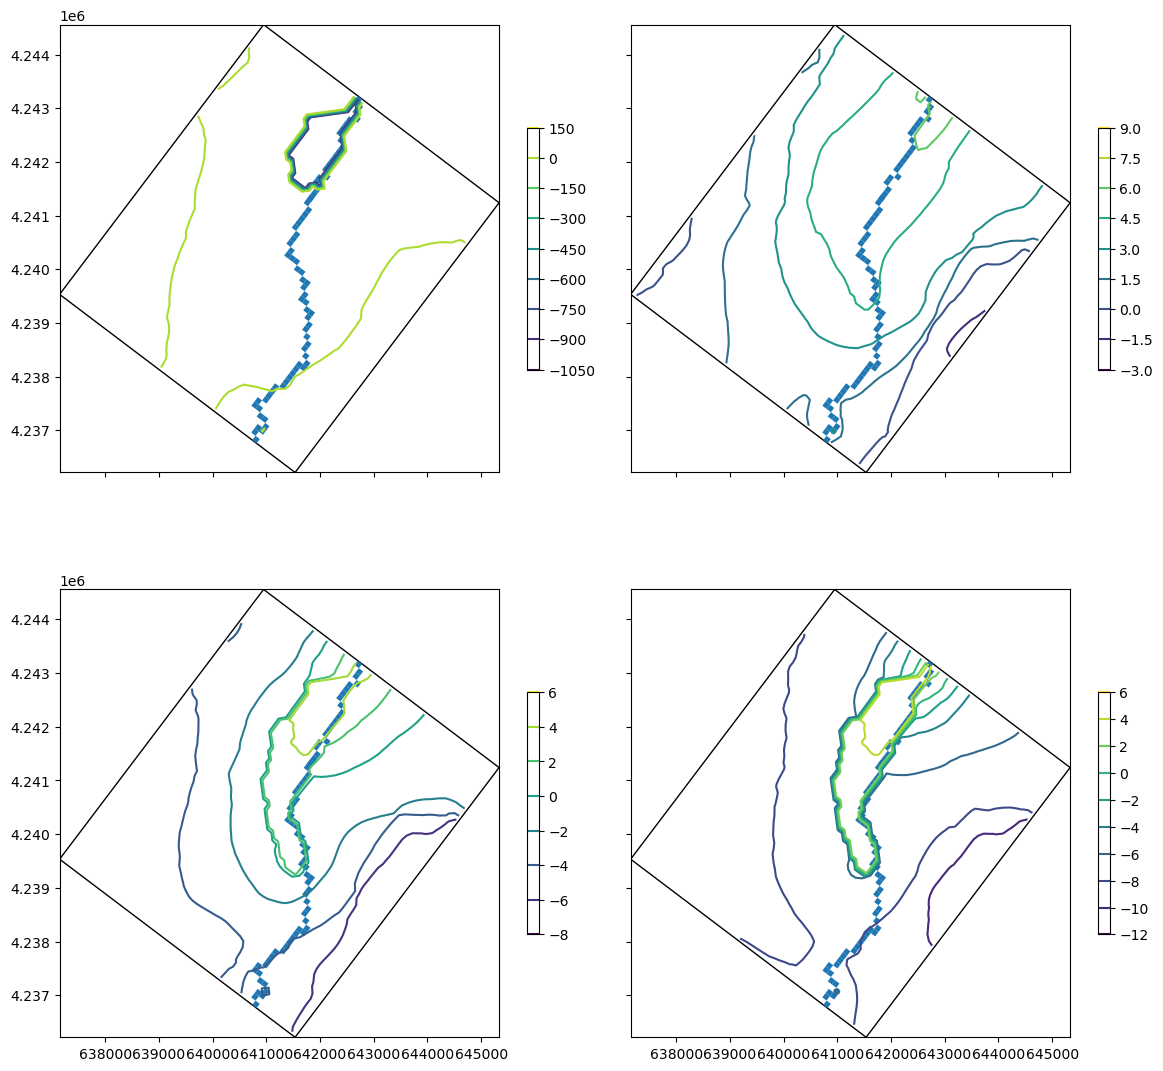

In [36]:
avg_sfr_lay = int(np.round(grid_sfr.k.mean()))

nx = 2
ny = 2
fig,ax = plt.subplots(ny,nx, figsize=(12,12),sharex=True, sharey=True)

# fig.tight_layout()
for n,t in enumerate(spd_stp[::90][1:]):
    head = hdobj.get_data(t)[avg_sfr_lay] #m.dis.top.array - 
        
    ax_n = ax[int(n / nx), n % nx]
    mapview = flopy.plot.PlotMapView(model=m,ax=ax_n)
    m_domain.plot(ax=ax_n,color='none')
    im = mapview.contour_array(head, masked_values=[-999.99], ax=ax_n)
    grid_sfr.plot(ax=ax_n)
# vmin, vmax from visual inspection but could be added with code
#     im = ax_n.contour(head[avg_sfr_lay])

    ax_n.set_aspect(1)
    plt.colorbar(im, ax=ax_n, shrink = 0.4)
# fig.subplots_adjust(wspace=0.2, hspace=-.5)
fig.tight_layout()